In [1]:
import torch
import numpy as np
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.notebook import tqdm
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt

torch.manual_seed(42)

BATCH_SIZE = 128
NUM_EPOCHS = 30
DISPLAY_LIMIT = 3
EVAL_INTERVAL = 1
DISPLAY_DURING_EVAL  = True
PATIENCE = 5
Z_DIM = 32
DENSE_SIZE = 1024
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE


'cuda'

In [2]:

class ImageDataset(Dataset):
    def __init__(self, npy_path: str):
        # Load list of episodes (each episode is [steps, h, w, c])
        self.data_array = np.load(npy_path, allow_pickle=True)
        # Compute cumulative lengths to index into flattened dataset
        lengths = [episode.shape[0] for episode in self.data_array]
        self.cum_lengths = np.cumsum(lengths)

    def __len__(self):
        return self.cum_lengths[-1]

    def __getitem__(self, global_idx: int):
        # Find which episode this index belongs to
        episode_idx = np.searchsorted(self.cum_lengths, global_idx, side='right')
        start = 0 if episode_idx == 0 else self.cum_lengths[episode_idx - 1]
        local_idx = global_idx - start

        image = self.data_array[episode_idx][local_idx].astype('float32') / 255.0
        image = torch.tensor(image).permute(2, 0, 1)
        return image


test = ImageDataset('../data/600k_rollouts.npy')
print(len(test))




600000


In [3]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_channels=3, latent_dim=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # 96 -> 48
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),             # 48 -> 24
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),            # 24 -> 12
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),           # 12 -> 6
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),           # 6 -> 6
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.mu = nn.Linear(512*6*6, latent_dim)
        self.logvar = nn.Linear(512*6*6, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        mu = self.mu(x) * 0.1
        logvar = self.logvar(x) * 0.1
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim=32, output_channels=3):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512*6*6)
        self.unflatten = nn.Unflatten(1, (512, 6, 6))
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),  # 6 -> 6
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 6 -> 12
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 12 -> 24
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 24 -> 48
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1),  # 48 -> 96
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = self.unflatten(x)
        x = self.deconv(x)
        return x


In [4]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, latent_dim=Z_DIM):
        super().__init__()
        self.encoder = Encoder(image_channels, latent_dim)
        self.decoder = Decoder(latent_dim, image_channels)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

In [5]:
class VAELoss(nn.Module):
    def __init__(self, r_loss_factor=1.0, beta=0.1, free_bits=0.03):
        """
        free_bits: minimum KL contribution per latent dimension
        beta: weight for KL term
        r_loss_factor: scales reconstruction loss
        """
        super().__init__()
        self.r_loss_factor = r_loss_factor
        self.beta = beta
        self.free_bits = free_bits
        self.mse_loss = nn.MSELoss()

    #def forward(self, input_image, decoder_output, mus, logvars, epoch):
        # Reconstruction Loss (MSE but summed over pixels per sample)
        # recon_loss = torch.sum((input_image - decoder_output) ** 2, dim=[1, 2, 3])
        # recon_loss = torch.mean(recon_loss) * self.r_loss_factor
        # recon_loss = self.mse_loss(decoder_output, input_image)

        # KL Divergence
        # kl_loss = -0.5 * torch.sum(1 + logvars - mus.pow(2) - logvars.exp(), dim=1)
        # kl_loss = torch.mean(kl_loss)
        # print(f"Reconstruction loss (MSE mean): {recon_loss.item():.6f}")
        # print(f"KL divergence: {kl_loss.item():.6f}")

    
        # kl_loss = torch.clamp(kl_loss, min=0.01)

        # return recon_loss* 1000 + self.beta * kl_loss
    
    def forward(self, input_image, decoder_output, mus, logvars, epoch=None):
        # Reconstruction loss
        recon_loss = self.mse_loss(decoder_output, input_image) * self.r_loss_factor

        # KL per latent dimension
        kl_per_dim = -0.5 * (1 + logvars - mus.pow(2) - logvars.exp())  # [batch, latent_dim]

        # Clamp each dimension to free_bits
        kl_per_dim = torch.clamp(kl_per_dim, min=self.free_bits)

        # Sum over dimensions, then mean over batch
        kl_loss = kl_per_dim.sum(dim=1).mean()

        # Total loss
        return recon_loss + self.beta * kl_loss


In [6]:
def display_image(autoencoder, test_dataloader, limit = None):
    limit = DISPLAY_LIMIT if limit is None else limit
    with torch.no_grad():  # note the parentheses
        autoencoder.eval()
        inputs = next(iter(test_dataloader)).to(DEVICE)
        outputs  = autoencoder(inputs)[0]
        rands = torch.rand((outputs.shape[0], 32)).to(DEVICE)
        rands_out = autoencoder.decoder(rands)

        orig = inputs[:limit].cpu()
        recon = outputs[:limit].cpu()
        rands_out = rands_out[:limit].cpu()

        orig_np = orig.permute(0,2,3,1).numpy()
        recon_np = recon.permute(0,2,3,1).numpy()
        rands_np = rands_out.permute(0,2,3,1).numpy()

        fig, axes = plt.subplots(limit, 3, figsize=(6, 3*limit))
        for i in range(limit):
            # Original image
            if limit  > 1:
                axes[i, 0].imshow(orig_np[i])
                axes[i, 0].set_title("Original")
                axes[i, 0].axis("off")

                # Reconstructed image
                axes[i, 1].imshow(recon_np[i])
                axes[i, 1].set_title("Reconstructed")
                axes[i, 1].axis("off")

                axes[i, 2].imshow(rands_np[i])
                axes[i, 2].set_title("Random")
                axes[i, 2].axis("off")
            else:
                axes[0].imshow(orig_np[i])
                axes[0].set_title("Original")
                axes[0].axis("off")

                axes[1].imshow(recon_np[i])
                axes[1].set_title("Reconstructed")
                axes[1].axis("off")

                axes[2].imshow(rands_np[i])
                axes[2].set_title("Random")
                axes[2].axis("off")


        plt.tight_layout()
        plt.show()

def evaluate(model, dataloader, loss_fn, epoch):
    avg_loss = 0
    model.eval()
    print("Evaluating...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval"):
            inputs = batch.to(DEVICE)
            outputs, mus, logvars = model(inputs)
            loss = loss_fn(outputs, inputs, mus, logvars, epoch)
            avg_loss += loss
    avg_loss = avg_loss/ (len(dataloader))

    if DISPLAY_DURING_EVAL:
        display_image(model, dataloader, 1)

    return avg_loss.item()
        

In [7]:
dataset = ImageDataset('../data/600k_rollouts.npy')
num_samples = len(dataset)
indices = np.arange(num_samples)
np.random.shuffle(indices)
split = int(0.8 * num_samples)
train_indices = indices[:split]
test_indices = indices[split:]

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_dataset, 64, shuffle=True)
test_dataloader = DataLoader(test_dataset, 64, shuffle=True)



In [8]:
vae = VAE(image_channels=3, latent_dim=32).to(DEVICE)
optim = torch.optim.Adam(vae.parameters(), lr=1e-4)  # Match Keras
loss_fn = VAELoss(r_loss_factor=10000, beta=0.01)     # Match Keras

# Storage for losses
losses = defaultdict(list)

x = torch.randn(4, 3, 96, 96).to(DEVICE)  # batch
mu, logvar = vae.encoder(x)
kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
print(kl.mean())



tensor(2.1219e-05, device='cuda:0', grad_fn=<MeanBackward0>)


EPOCH:   0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

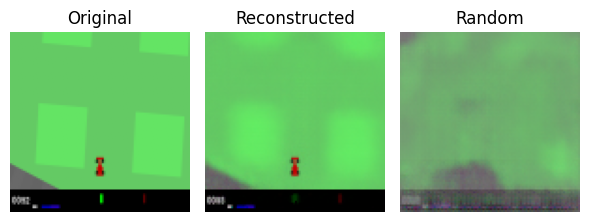

Epoch 1 test_loss: 7.6009


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

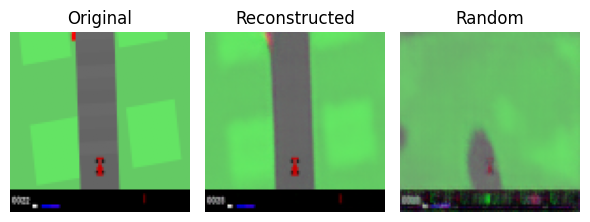

Epoch 2 test_loss: 5.6231


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

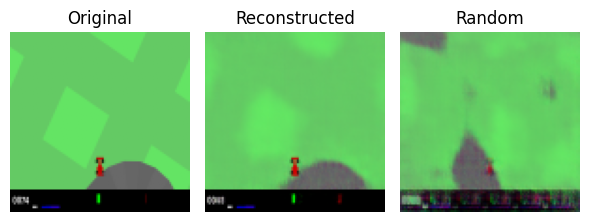

Epoch 3 test_loss: 4.9219


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

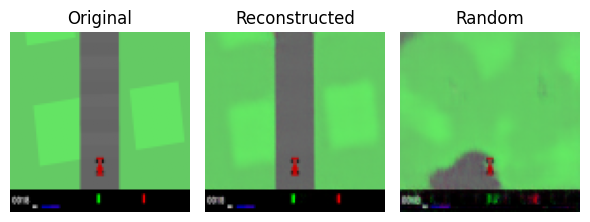

Epoch 4 test_loss: 4.2860


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

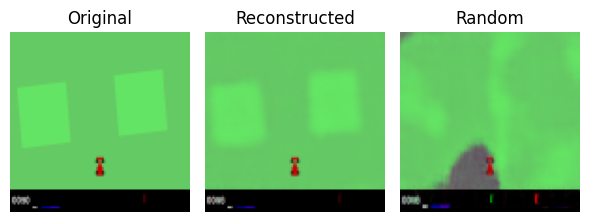

Epoch 5 test_loss: 3.8571


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

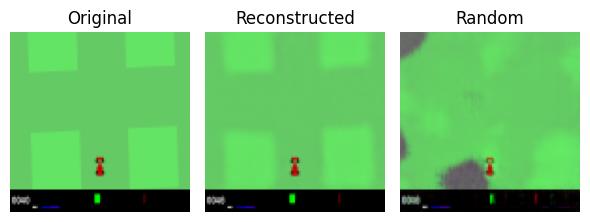

Epoch 6 test_loss: 3.4503


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

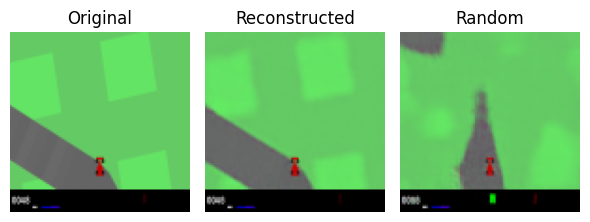

Epoch 7 test_loss: 3.1370


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

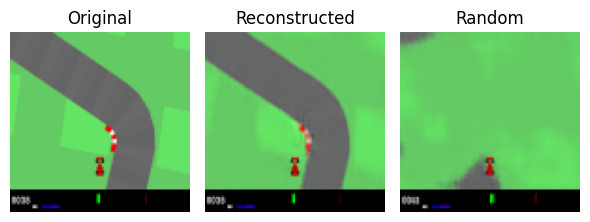

Epoch 8 test_loss: 2.8511


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

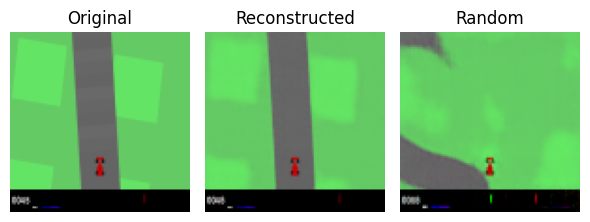

Epoch 9 test_loss: 2.6749


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

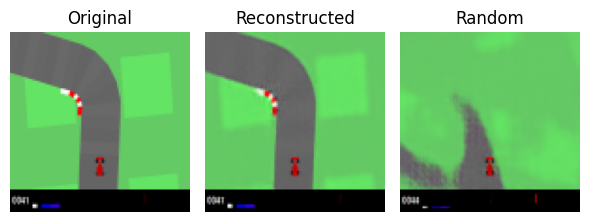

Epoch 10 test_loss: 2.5462


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

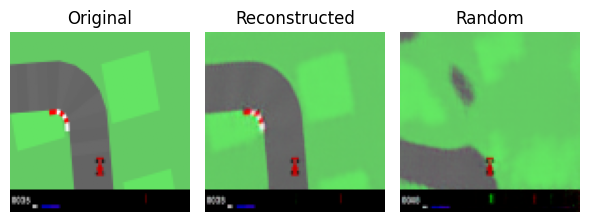

Epoch 11 test_loss: 2.4280


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

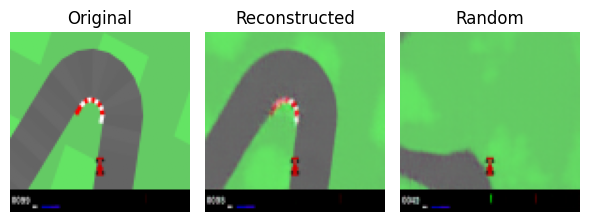

Epoch 12 test_loss: 2.3734


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

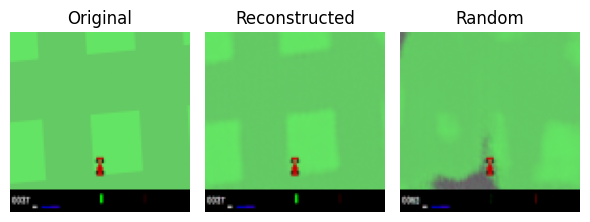

Epoch 13 test_loss: 2.2723


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

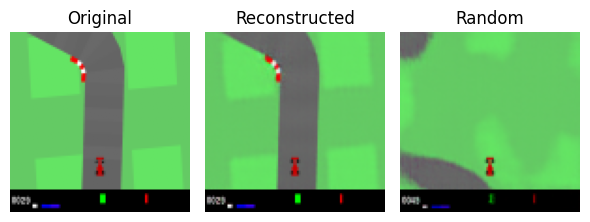

Epoch 14 test_loss: 2.2117


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

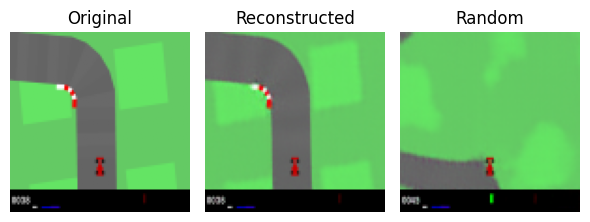

Epoch 15 test_loss: 2.1655


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

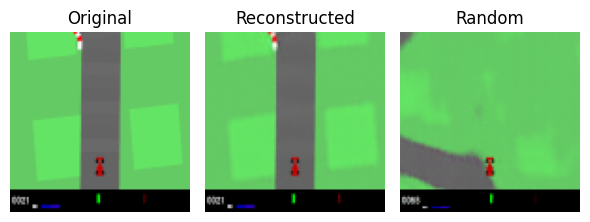

Epoch 16 test_loss: 2.0818


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

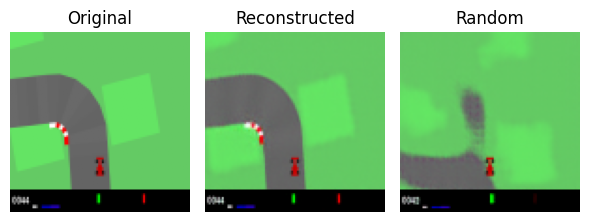

Epoch 17 test_loss: 2.0473


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

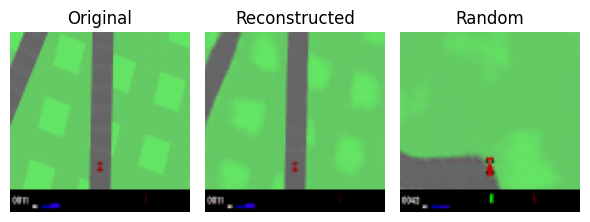

Epoch 18 test_loss: 2.0187


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

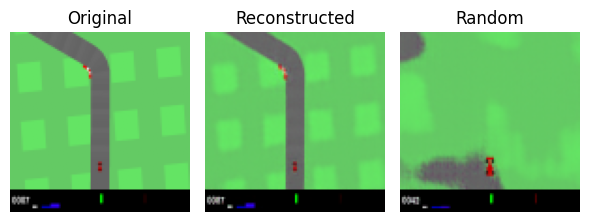

Epoch 19 test_loss: 1.9624


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

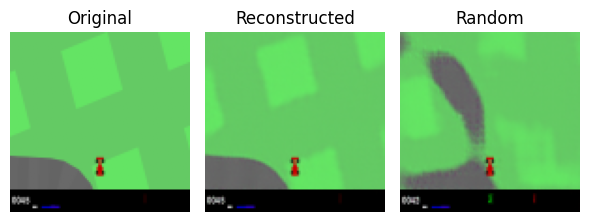

Epoch 20 test_loss: 1.9220


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

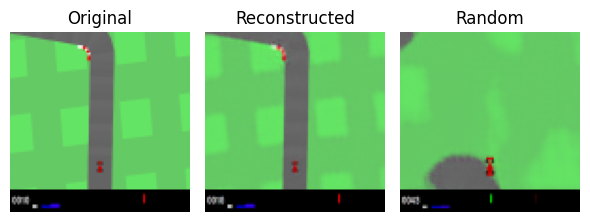

Epoch 21 test_loss: 1.9023


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

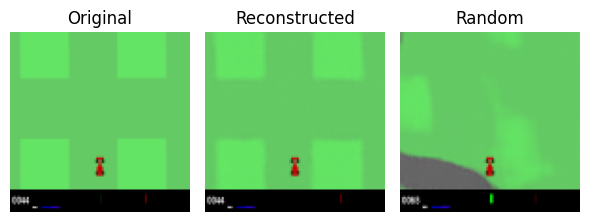

Epoch 22 test_loss: 1.8789


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

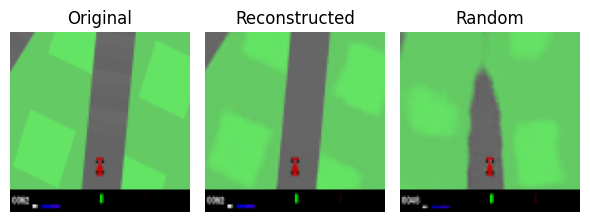

Epoch 23 test_loss: 1.8372


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

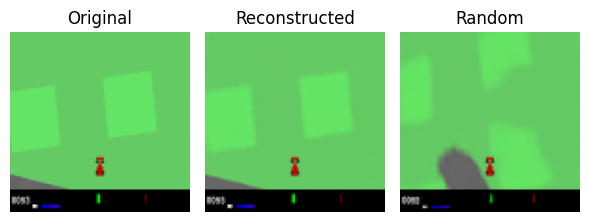

Epoch 24 test_loss: 1.8269


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

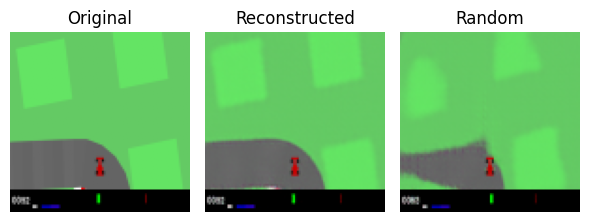

Epoch 25 test_loss: 1.7746


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

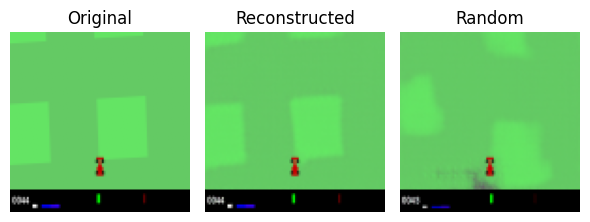

Epoch 26 test_loss: 1.7582


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

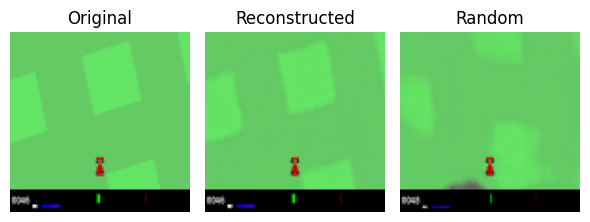

Epoch 27 test_loss: 1.7593


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

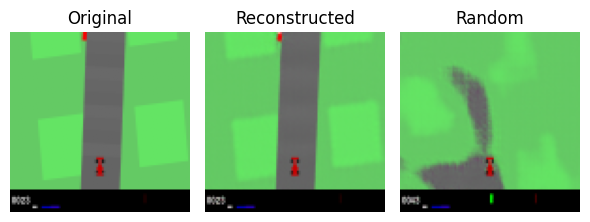

Epoch 28 test_loss: 1.7217


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

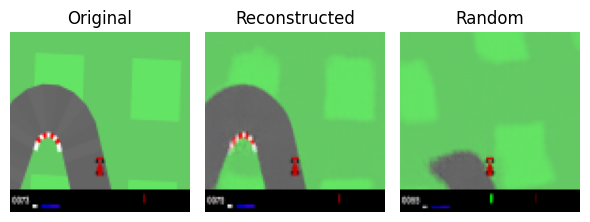

Epoch 29 test_loss: 1.6938


Train:   0%|          | 0/7500 [00:00<?, ?it/s]

Evaluating...


Eval:   0%|          | 0/1875 [00:00<?, ?it/s]

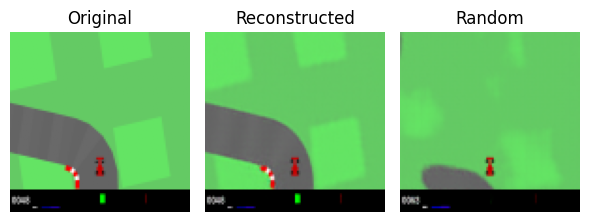

Epoch 30 test_loss: 1.6700
Training Complete!!!


In [9]:
best_val_loss = float('inf')
patience_counter = 0

for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc="EPOCH"):
    # --- Training ---
    avg_train_loss = 0
    vae.train()
    for batch in tqdm(train_dataloader, 'Train'):
        optim.zero_grad()
        inputs = batch.to(DEVICE)
        recon, mus, logvars = vae(inputs)
        loss = loss_fn(recon, inputs, mus, logvars, epoch)
        loss.backward()
        optim.step()
        avg_train_loss += loss.item()
    avg_train_loss /= len(train_dataloader)
    losses['train'].append(avg_train_loss)

    # --- Evaluation ---
    if epoch % EVAL_INTERVAL == 0:
        avg_test_loss = evaluate(vae, test_dataloader, loss_fn, epoch)
        losses['test'].append(avg_test_loss)
        print(f"Epoch {epoch} test_loss: {avg_test_loss:.4f}")

        # Early stopping check
        if avg_test_loss < best_val_loss:
            
            best_val_loss = avg_test_loss
            patience_counter = 0
            # Save best model
            torch.save(vae.state_dict(), f"../models/best_vae_{epoch}.pth")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered at epoch {epoch}")
                break
print("Training Complete!!!")


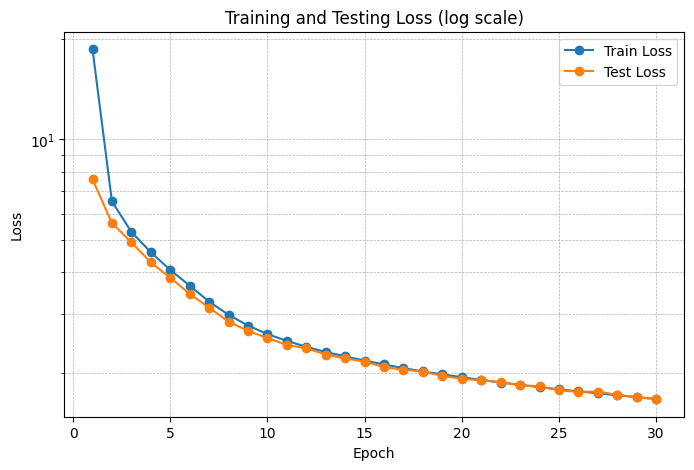

In [10]:
import matplotlib.pyplot as plt


train_losses = losses["train"]
test_losses  = losses["test"]

train_epochs = range(1, len(train_losses)+1)
test_epochs  = range(EVAL_INTERVAL, len(train_losses)+1, EVAL_INTERVAL)

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(train_epochs, train_losses, label="Train Loss", marker='o')
plt.plot(test_epochs, test_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")  # <-- log scale for y-axis
plt.title("Training and Testing Loss (log scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


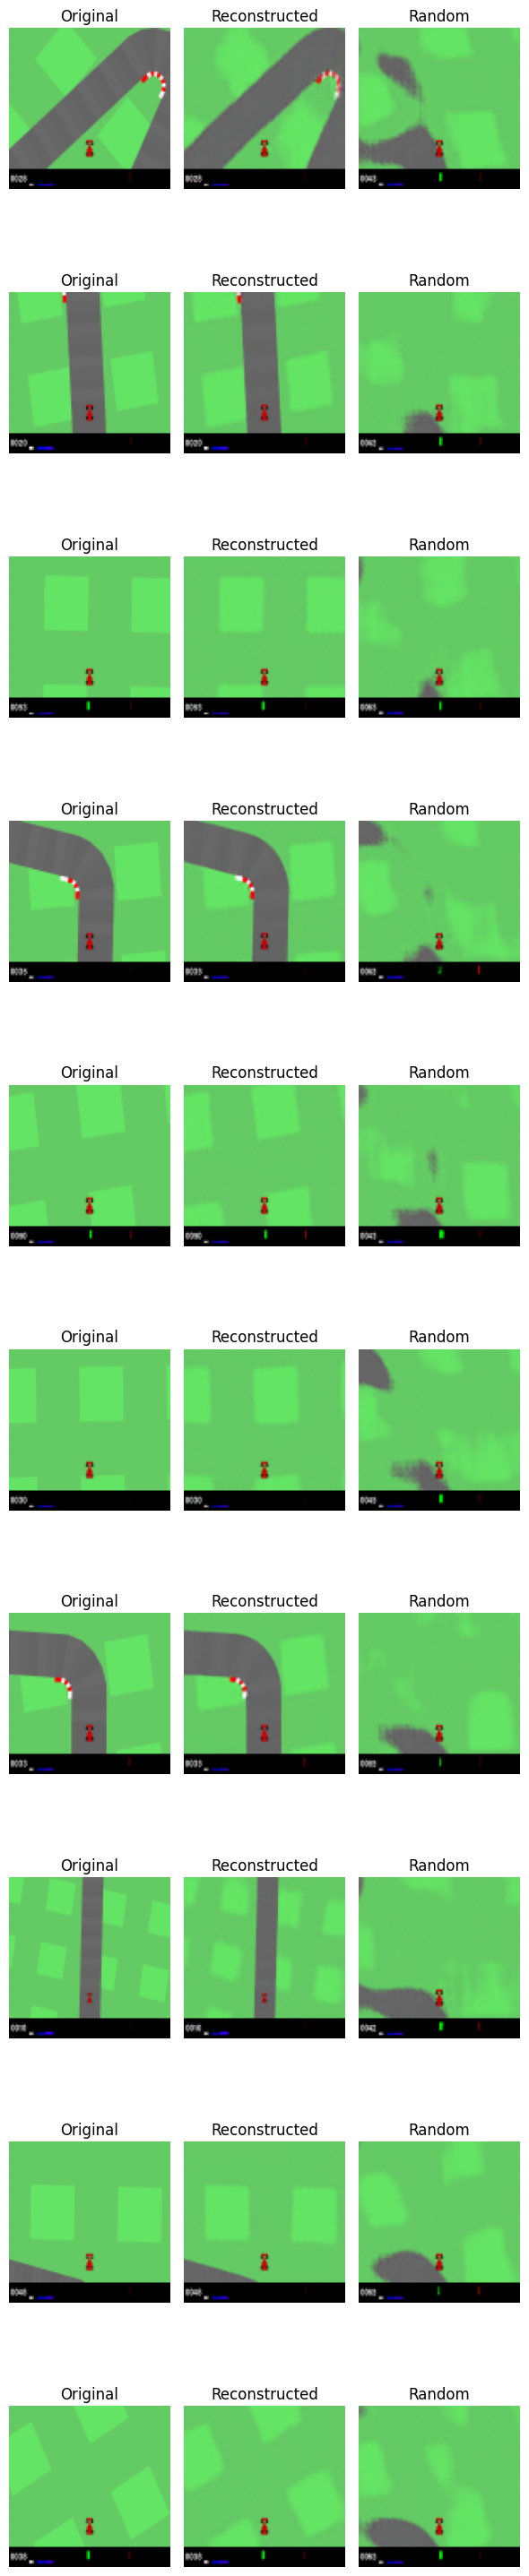

In [11]:
display_image(vae, test_dataloader, 10)

In [12]:
pytorch_total_params = sum(p.numel() for p in vae.parameters())
print(f"Total Params: {pytorch_total_params}")

Total Params: 5528067


In [13]:
if test_losses[-1] < 0.500:
    torch.save(vae.encoder, "../models/vae_full.pth")

In [15]:
torch.save(vae.encoder, "../models/vae30_full.pth")

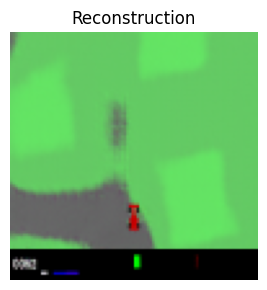

In [51]:
def display_single(model: nn.Module, vector: torch.Tensor = None):
    model.eval()
    with torch.no_grad():
        if vector == None:
            vector = torch.rand((1,32))
        
        vector = vector.to(DEVICE)
        model = model.to(DEVICE)
        output = model(vector)
        recon = output.cpu().permute(0,2,3,1).numpy()

        fig, axes = plt.subplots(1, 1, figsize=(6, 3))
            
        axes.imshow(recon[0])
        axes.set_title("Reconstruction")
        axes.axis("off")


        plt.tight_layout()
        plt.show()

decoder = vae.decoder        
display_single(decoder)